In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, random_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 313kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.82MB/s]

Training dataset size: 60000
Test dataset size: 10000


Training set size: 48000
Validation set size: 12000
Test set size: 10000


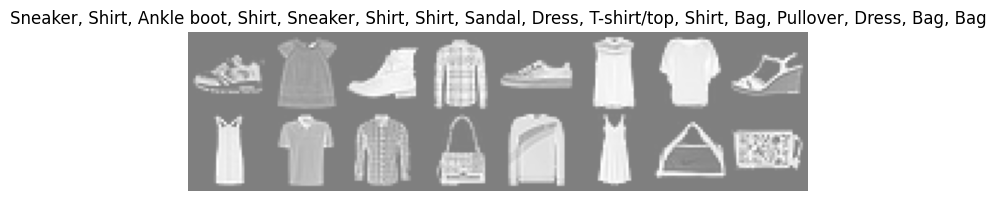

In [ ]:
# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize some samples
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]),
       ', '.join([class_names[labels[j]] for j in range(16)]))

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Initialize model
ann_model = ANN().to(device)
print(ann_model)

ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Initialize model
cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inplace=

In [ ]:
def train_model(model, train_loader, val_loader, model_name, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Training {model_name}...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train ANN
ann_train_loss, ann_val_loss, ann_train_acc, ann_val_acc = train_model(
    ann_model, train_loader, val_loader, "ANN"
)

# Train CNN
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model(
    cnn_model, train_loader, val_loader, "CNN"
)

Training ANN...
Epoch [1/15], Train Loss: 0.6575, Train Acc: 75.65%, Val Loss: 0.4778, Val Acc: 82.88%
Epoch [2/15], Train Loss: 0.4374, Train Acc: 84.17%, Val Loss: 0.3969, Val Acc: 85.67%
Epoch [3/15], Train Loss: 0.3951, Train Acc: 85.75%, Val Loss: 0.3762, Val Acc: 86.15%
Epoch [4/15], Train Loss: 0.3687, Train Acc: 86.81%, Val Loss: 0.3714, Val Acc: 86.42%
Epoch [5/15], Train Loss: 0.3572, Train Acc: 86.86%, Val Loss: 0.3416, Val Acc: 87.78%
Epoch [6/15], Train Loss: 0.3161, Train Acc: 88.42%, Val Loss: 0.3228, Val Acc: 88.18%
Epoch [7/15], Train Loss: 0.3044, Train Acc: 88.85%, Val Loss: 0.3167, Val Acc: 88.88%
Epoch [8/15], Train Loss: 0.2953, Train Acc: 89.08%, Val Loss: 0.3129, Val Acc: 88.62%
Epoch [9/15], Train Loss: 0.2889, Train Acc: 89.22%, Val Loss: 0.3131, Val Acc: 88.84%
Epoch [10/15], Train Loss: 0.2837, Train Acc: 89.41%, Val Loss: 0.3085, Val Acc: 88.91%
Epoch [11/15], Train Loss: 0.2610, Train Acc: 90.35%, Val Loss: 0.3033, Val Acc: 89.08%
Epoch [12/15], Train Loss

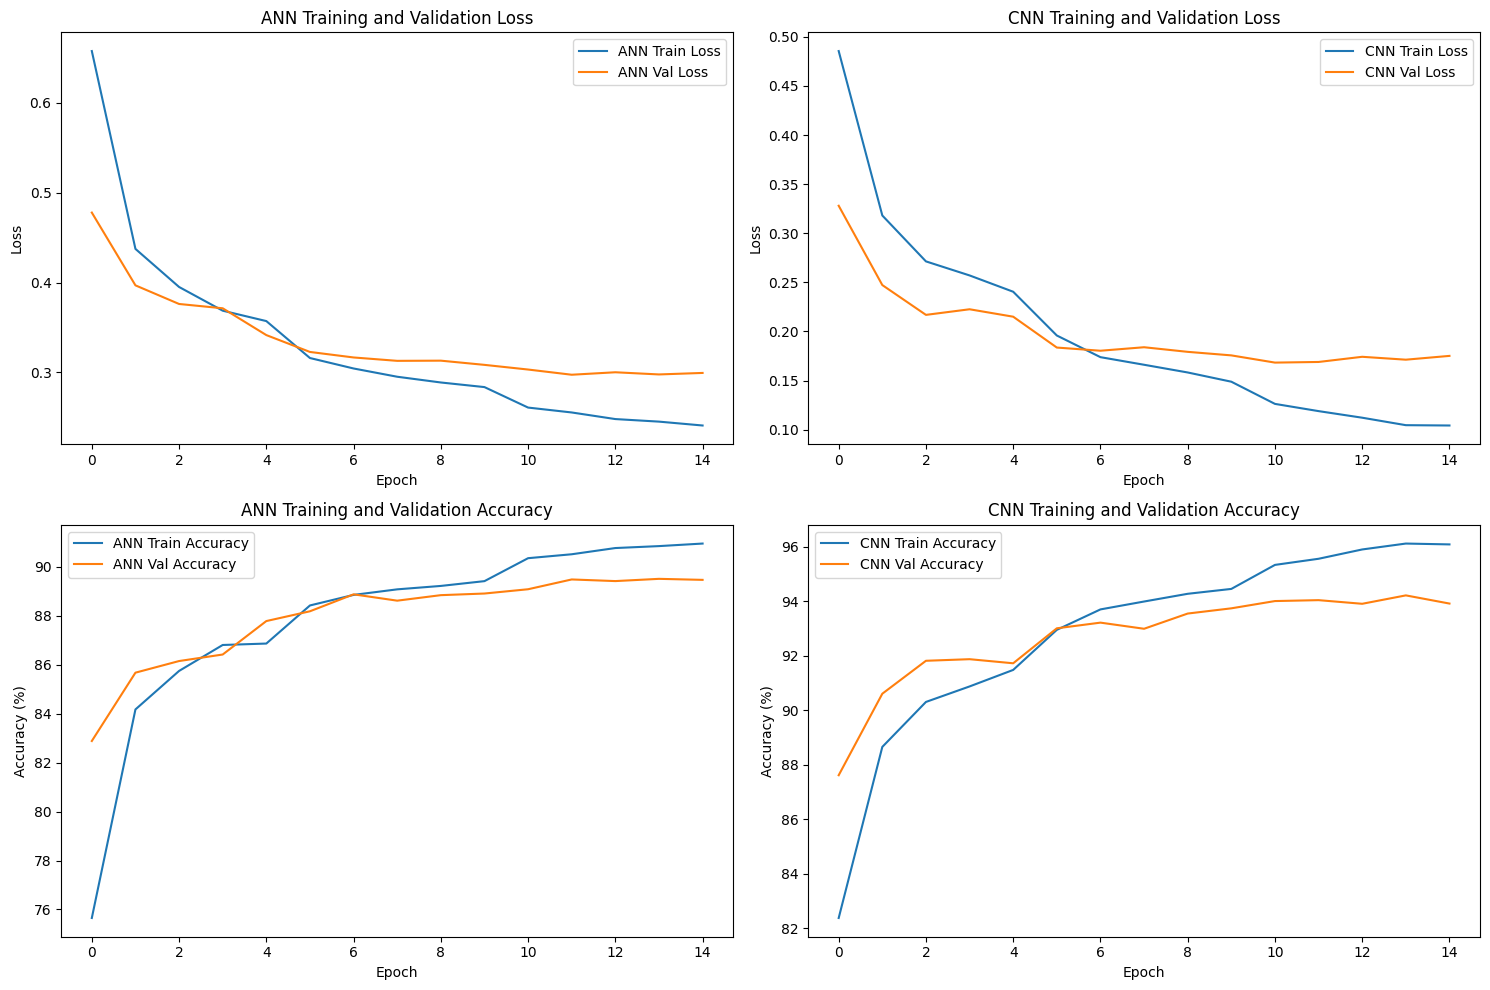

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(ann_train_loss, label='ANN Train Loss')
axes[0, 0].plot(ann_val_loss, label='ANN Val Loss')
axes[0, 0].set_title('ANN Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(cnn_train_loss, label='CNN Train Loss')
axes[0, 1].plot(cnn_val_loss, label='CNN Val Loss')
axes[0, 1].set_title('CNN Training and Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Accuracy plots
axes[1, 0].plot(ann_train_acc, label='ANN Train Accuracy')
axes[1, 0].plot(ann_val_acc, label='ANN Val Accuracy')
axes[1, 0].set_title('ANN Training and Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()

axes[1, 1].plot(cnn_train_acc, label='CNN Train Accuracy')
axes[1, 1].plot(cnn_val_acc, label='CNN Val Accuracy')
axes[1, 1].set_title('CNN Training and Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    return accuracy, all_predictions, all_labels

# Evaluate both models
ann_accuracy, ann_predictions, ann_labels = evaluate_model(ann_model, test_loader, "ANN")
cnn_accuracy, cnn_predictions, cnn_labels = evaluate_model(cnn_model, test_loader, "CNN")

ANN Test Accuracy: 88.94%
CNN Test Accuracy: 94.27%


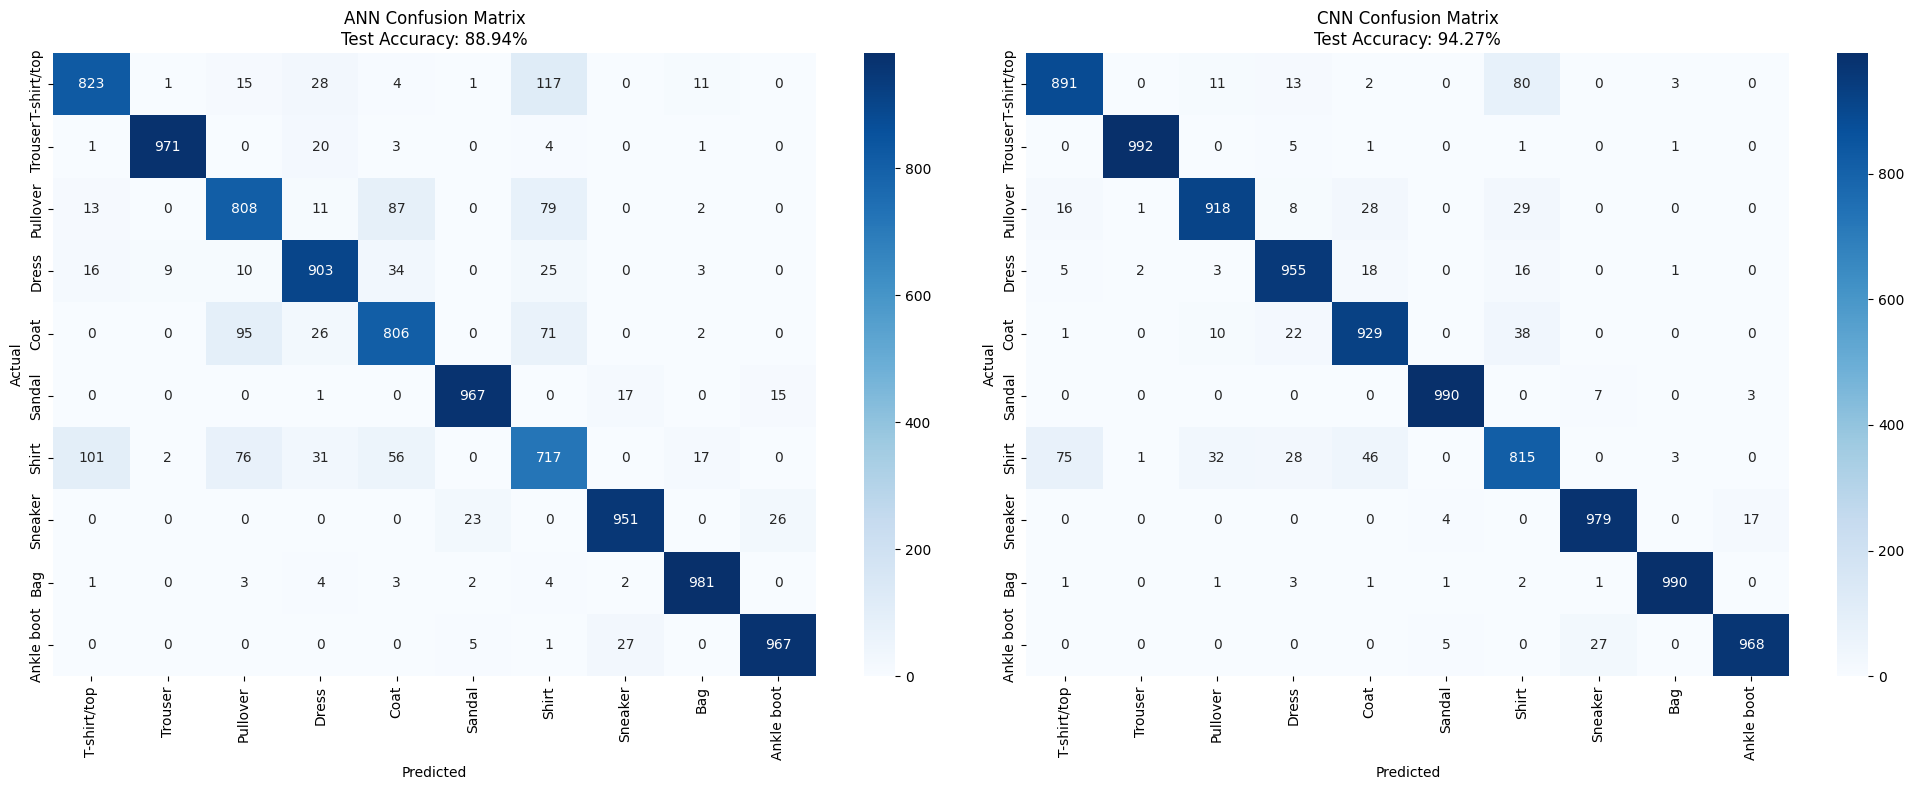

In [ ]:
# Create confusion matrices
ann_cm = confusion_matrix(ann_labels, ann_predictions)
cnn_cm = confusion_matrix(cnn_labels, cnn_predictions)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ANN Confusion Matrix
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'ANN Confusion Matrix\nTest Accuracy: {ann_accuracy:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# CNN Confusion Matrix
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'CNN Confusion Matrix\nTest Accuracy: {cnn_accuracy:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Detailed analysis of confusion between similar classes
print("=" * 60)
print("ANALYSIS OF CONFUSION BETWEEN VISUALLY SIMILAR CLASSES")
print("=" * 60)

# Focus on visually similar pairs
similar_pairs = [
    ('Shirt', 6, 'T-shirt/top', 0),
    ('Shirt', 6, 'Coat', 4),
    ('Shirt', 6, 'Pullover', 2),
    ('Coat', 4, 'Pullover', 2),
    ('Sandal', 5, 'Sneaker', 7),
    ('Sneaker', 7, 'Ankle boot', 9)
]

for name1, idx1, name2, idx2 in similar_pairs:
    ann_confusion = ann_cm[idx1, idx2] + ann_cm[idx2, idx1]
    cnn_confusion = cnn_cm[idx1, idx2] + cnn_cm[idx2, idx1]

    print(f"\n{name1} vs {name2}:")
    print(f"  ANN confusion: {ann_confusion} samples")
    print(f"  CNN confusion: {cnn_confusion} samples")
    improvement = ((ann_confusion - cnn_confusion) / ann_confusion * 100) if ann_confusion > 0 else 0
    print(f"  CNN improvement: {improvement:.1f}% reduction in confusion")

# Overall comparison
print("\n" + "=" * 60)
print("OVERALL PERFORMANCE COMPARISON")
print("=" * 60)
print(f"ANN Test Accuracy: {ann_accuracy:.2f}%")
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}%")
print(f"CNN Improvement: {cnn_accuracy - ann_accuracy:.2f}% absolute")
print(f"CNN Improvement: {((cnn_accuracy - ann_accuracy) / ann_accuracy * 100):.1f}% relative")

ANALYSIS OF CONFUSION BETWEEN VISUALLY SIMILAR CLASSES

Shirt vs T-shirt/top:
  ANN confusion: 218 samples
  CNN confusion: 155 samples
  CNN improvement: 28.9% reduction in confusion

Shirt vs Coat:
  ANN confusion: 127 samples
  CNN confusion: 84 samples
  CNN improvement: 33.9% reduction in confusion

Shirt vs Pullover:
  ANN confusion: 155 samples
  CNN confusion: 61 samples
  CNN improvement: 60.6% reduction in confusion

Coat vs Pullover:
  ANN confusion: 182 samples
  CNN confusion: 38 samples
  CNN improvement: 79.1% reduction in confusion

Sandal vs Sneaker:
  ANN confusion: 40 samples
  CNN confusion: 11 samples
  CNN improvement: 72.5% reduction in confusion

Sneaker vs Ankle boot:
  ANN confusion: 53 samples
  CNN confusion: 44 samples
  CNN improvement: 17.0% reduction in confusion

OVERALL PERFORMANCE COMPARISON
ANN Test Accuracy: 88.94%
CNN Test Accuracy: 94.27%
CNN Improvement: 5.33% absolute
CNN Improvement: 6.0% relative


In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Initialize model
ann_model = ANN().to(device)
print("ANN Model:")
print(ann_model)

ANN Model:
ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Initialize model
cnn_model = CNN().to(device)
print("CNN Model:")
print(cnn_model)

CNN Model:
CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2

In [ ]:
def train_model_enhanced(model, train_loader, val_loader, model_name, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Enhanced learning rate scheduler - reduces LR when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Training {model_name}...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train ANN
print("=" * 50)
ann_train_loss, ann_val_loss, ann_train_acc, ann_val_acc = train_model_enhanced(
    ann_model, train_loader, val_loader, "ANN"
)

# Train CNN
print("=" * 50)
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model_enhanced(
    cnn_model, train_loader, val_loader, "CNN"
)

Training ANN...
Epoch [1/15], LR: 0.001000, Train Loss: 0.6520, Train Acc: 75.90%, Val Loss: 0.4438, Val Acc: 83.48%
Epoch [2/15], LR: 0.001000, Train Loss: 0.4342, Train Acc: 84.28%, Val Loss: 0.3994, Val Acc: 85.44%
Epoch [3/15], LR: 0.001000, Train Loss: 0.3922, Train Acc: 85.65%, Val Loss: 0.3768, Val Acc: 86.26%
Epoch [4/15], LR: 0.001000, Train Loss: 0.3696, Train Acc: 86.50%, Val Loss: 0.3633, Val Acc: 86.73%
Epoch [5/15], LR: 0.001000, Train Loss: 0.3540, Train Acc: 87.10%, Val Loss: 0.3351, Val Acc: 88.04%
Epoch [6/15], LR: 0.001000, Train Loss: 0.3402, Train Acc: 87.58%, Val Loss: 0.3265, Val Acc: 87.97%
Epoch [7/15], LR: 0.001000, Train Loss: 0.3283, Train Acc: 87.96%, Val Loss: 0.3167, Val Acc: 88.43%
Epoch [8/15], LR: 0.001000, Train Loss: 0.3186, Train Acc: 88.26%, Val Loss: 0.3214, Val Acc: 88.28%
Epoch [9/15], LR: 0.001000, Train Loss: 0.3085, Train Acc: 88.77%, Val Loss: 0.3211, Val Acc: 88.35%
Epoch [10/15], LR: 0.001000, Train Loss: 0.3032, Train Acc: 88.76%, Val Los

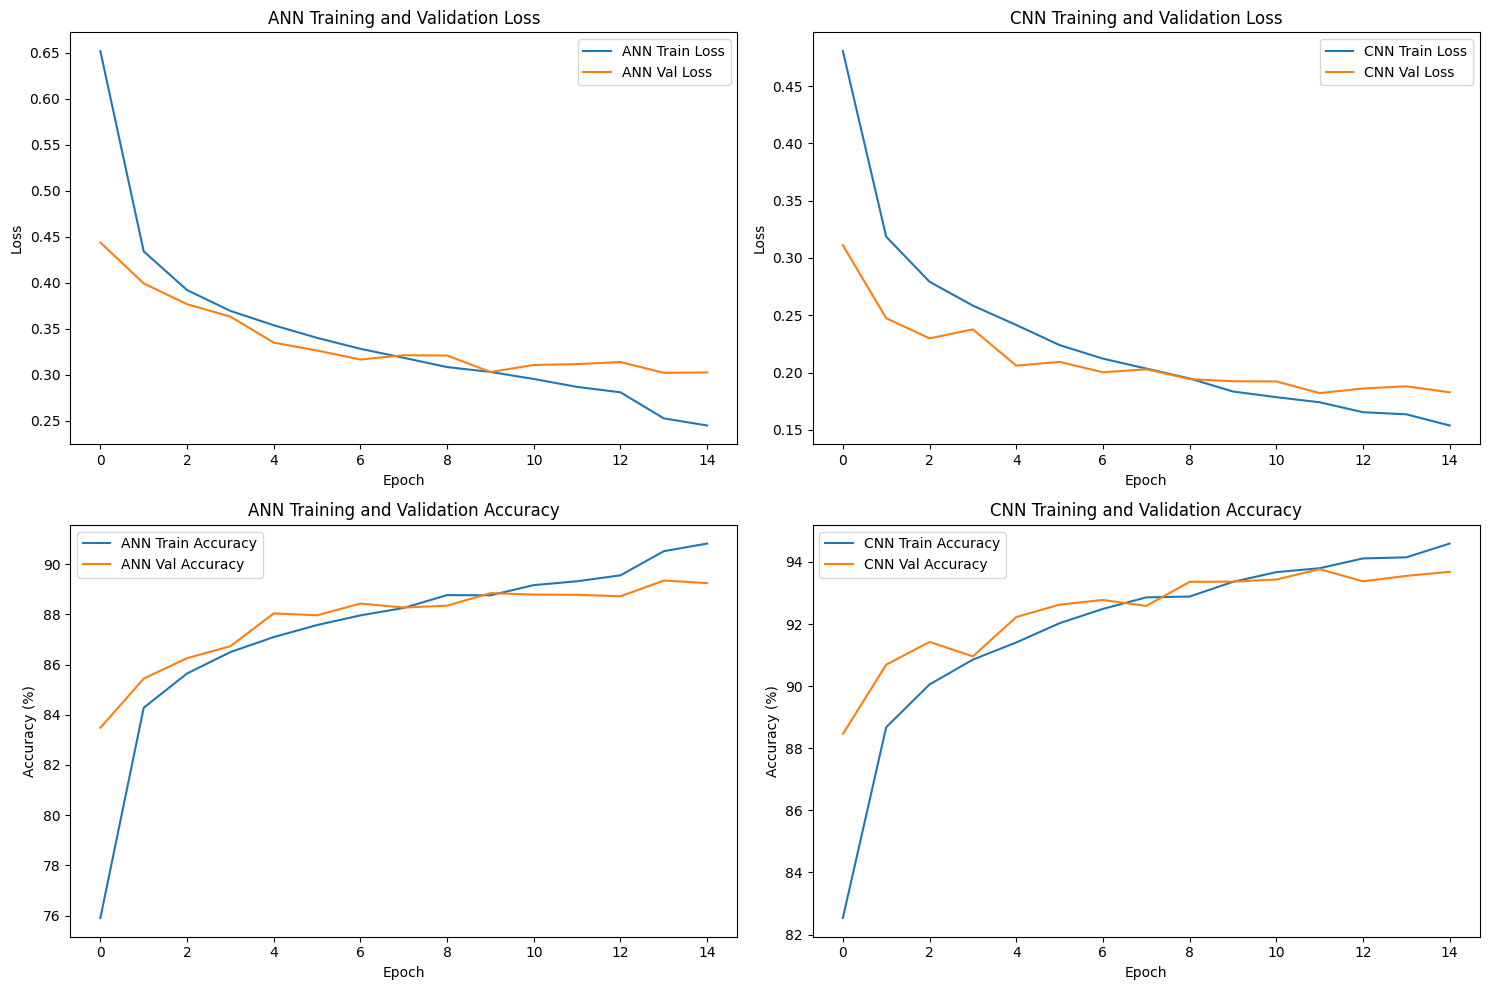

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(ann_train_loss, label='ANN Train Loss')
axes[0, 0].plot(ann_val_loss, label='ANN Val Loss')
axes[0, 0].set_title('ANN Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(cnn_train_loss, label='CNN Train Loss')
axes[0, 1].plot(cnn_val_loss, label='CNN Val Loss')
axes[0, 1].set_title('CNN Training and Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Accuracy plots
axes[1, 0].plot(ann_train_acc, label='ANN Train Accuracy')
axes[1, 0].plot(ann_val_acc, label='ANN Val Accuracy')
axes[1, 0].set_title('ANN Training and Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()

axes[1, 1].plot(cnn_train_acc, label='CNN Train Accuracy')
axes[1, 1].plot(cnn_val_acc, label='CNN Val Accuracy')
axes[1, 1].set_title('CNN Training and Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

ANN Test Accuracy: 88.38%
CNN Test Accuracy: 93.41%


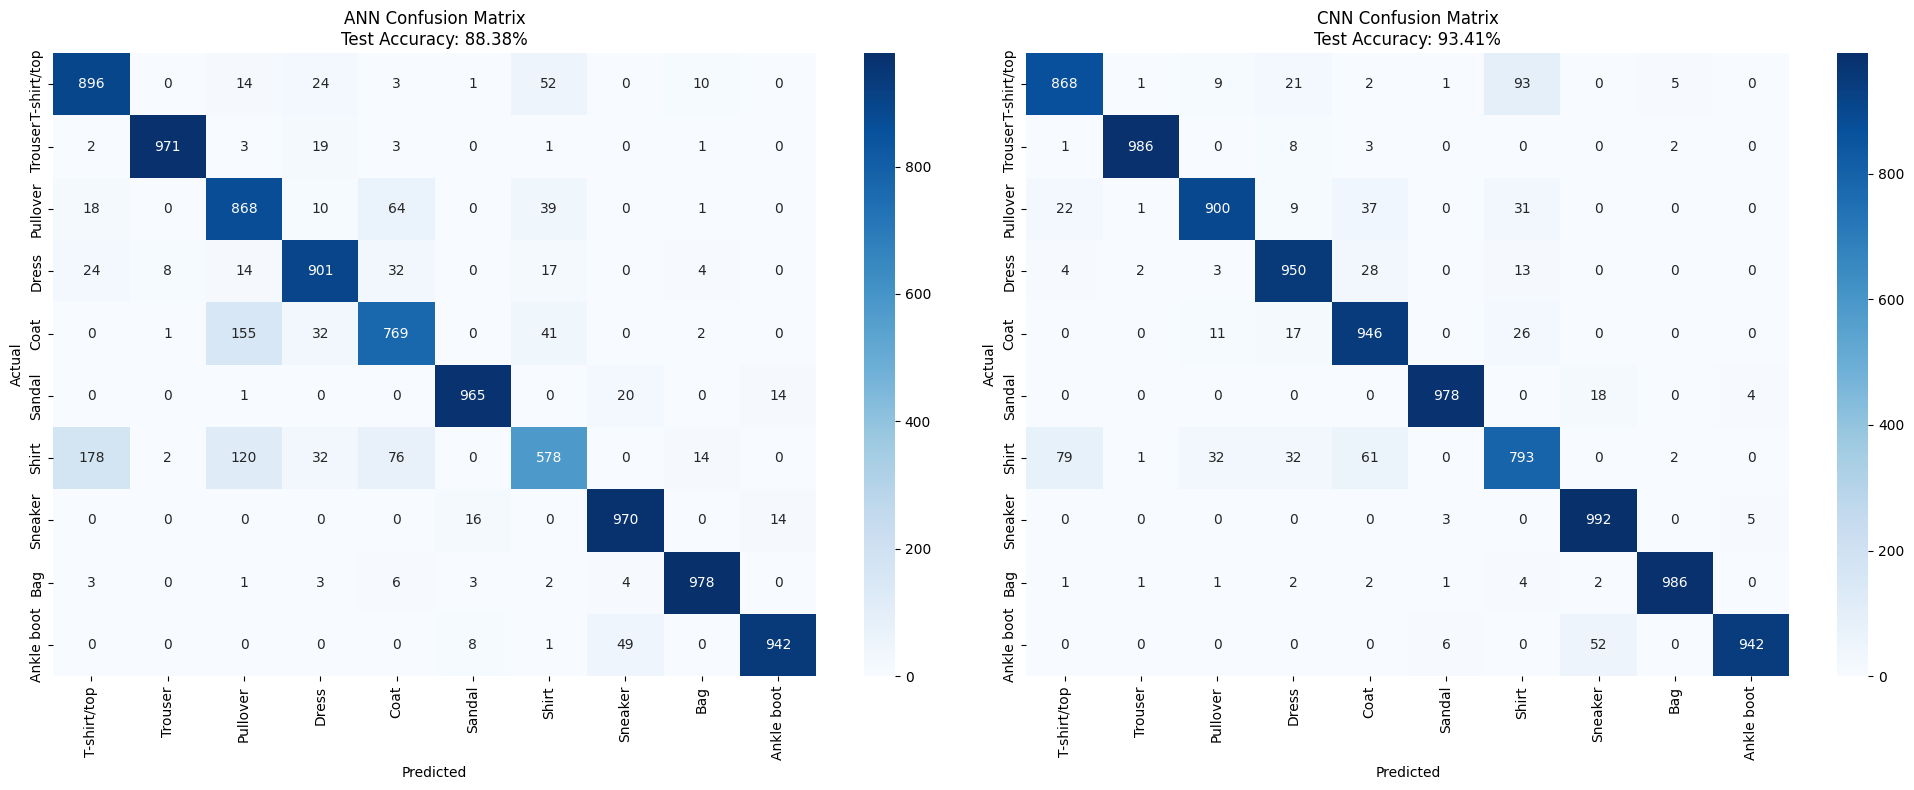

In [ ]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    return accuracy, all_predictions, all_labels

# Evaluate both models
print("=" * 50)
ann_accuracy, ann_predictions, ann_labels = evaluate_model(ann_model, test_loader, "ANN")
cnn_accuracy, cnn_predictions, cnn_labels = evaluate_model(cnn_model, test_loader, "CNN")

# Create confusion matrices
ann_cm = confusion_matrix(ann_labels, ann_predictions)
cnn_cm = confusion_matrix(cnn_labels, cnn_predictions)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ANN Confusion Matrix
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'ANN Confusion Matrix\nTest Accuracy: {ann_accuracy:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# CNN Confusion Matrix
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'CNN Confusion Matrix\nTest Accuracy: {cnn_accuracy:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("ANN vs CNN PERFORMANCE COMPARISON")
print("=" * 60)

# Overall performance comparison
print(f"\nOVERALL PERFORMANCE:")
print(f"ANN Test Accuracy: {ann_accuracy:.2f}%")
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}%")
print(f"CNN Improvement: {cnn_accuracy - ann_accuracy:.2f}% absolute")
print(f"CNN Improvement: {((cnn_accuracy - ann_accuracy) / ann_accuracy * 100):.1f}% relative")

print("\n" + "=" * 60)
print("CONFUSION ANALYSIS - VISUALLY SIMILAR CLASSES")
print("=" * 60)

# Focus on visually similar pairs
similar_pairs = [
    ('Shirt', 6, 'T-shirt/top', 0),
    ('Shirt', 6, 'Coat', 4),
    ('Shirt', 6, 'Pullover', 2),
    ('Coat', 4, 'Pullover', 2),
    ('Sandal', 5, 'Sneaker', 7),
    ('Sneaker', 7, 'Ankle boot', 9)
]

print("\nConfusion between similar classes (combined both directions):")
for name1, idx1, name2, idx2 in similar_pairs:
    ann_confusion = ann_cm[idx1, idx2] + ann_cm[idx2, idx1]
    cnn_confusion = cnn_cm[idx1, idx2] + cnn_cm[idx2, idx1]

    print(f"\n{name1} ↔ {name2}:")
    print(f"  ANN: {ann_confusion} confused samples")
    print(f"  CNN: {cnn_confusion} confused samples")

    if ann_confusion > 0:
        improvement = ((ann_confusion - cnn_confusion) / ann_confusion * 100)
        print(f"  CNN reduction: {improvement:.1f}%")
    else:
        print(f"  CNN reduction: N/A")

# Detailed shirt-related confusion analysis
print("\n" + "=" * 60)
print("DETAILED SHIRT CONFUSION ANALYSIS")
print("=" * 60)

shirt_idx = 6
shirt_confusing_classes = [0, 2, 4]  # T-shirt, Pullover, Coat

print(f"\nShirt (class 6) confusion patterns:")
print("Class misclassified as Shirt:")
for class_idx in range(10):
    if class_idx != shirt_idx:
        ann_misclassified = ann_cm[class_idx, shirt_idx]
        cnn_misclassified = cnn_cm[class_idx, shirt_idx]
        if ann_misclassified > 0 or cnn_misclassified > 0:
            print(f"  {class_names[class_idx]} → Shirt: ANN={ann_misclassified}, CNN={cnn_misclassified}")

print("\nShirt misclassified as other classes:")
for class_idx in range(10):
    if class_idx != shirt_idx:
        ann_misclassified = ann_cm[shirt_idx, class_idx]
        cnn_misclassified = cnn_cm[shirt_idx, class_idx]
        if ann_misclassified > 0 or cnn_misclassified > 0:
            print(f"  Shirt → {class_names[class_idx]}: ANN={ann_misclassified}, CNN={cnn_misclassified}")

# Calculate total confusion for shirts
total_shirt_confusion_ann = np.sum(ann_cm[shirt_idx, :]) - ann_cm[shirt_idx, shirt_idx]
total_shirt_confusion_cnn = np.sum(cnn_cm[shirt_idx, :]) - cnn_cm[shirt_idx, shirt_idx]

print(f"\nTotal shirt confusion:")
print(f"  ANN: {total_shirt_confusion_ann} misclassified samples")
print(f"  CNN: {total_shirt_confusion_cnn} misclassified samples")

ANN vs CNN PERFORMANCE COMPARISON

OVERALL PERFORMANCE:
ANN Test Accuracy: 88.38%
CNN Test Accuracy: 93.41%
CNN Improvement: 5.03% absolute
CNN Improvement: 5.7% relative

CONFUSION ANALYSIS - VISUALLY SIMILAR CLASSES

Confusion between similar classes (combined both directions):

Shirt ↔ T-shirt/top:
  ANN: 230 confused samples
  CNN: 172 confused samples
  CNN reduction: 25.2%

Shirt ↔ Coat:
  ANN: 117 confused samples
  CNN: 87 confused samples
  CNN reduction: 25.6%

Shirt ↔ Pullover:
  ANN: 159 confused samples
  CNN: 63 confused samples
  CNN reduction: 60.4%

Coat ↔ Pullover:
  ANN: 219 confused samples
  CNN: 48 confused samples
  CNN reduction: 78.1%

Sandal ↔ Sneaker:
  ANN: 36 confused samples
  CNN: 21 confused samples
  CNN reduction: 41.7%

Sneaker ↔ Ankle boot:
  ANN: 63 confused samples
  CNN: 57 confused samples
  CNN reduction: 9.5%

DETAILED SHIRT CONFUSION ANALYSIS

Shirt (class 6) confusion patterns:
Class misclassified as Shirt:
  T-shirt/top → Shirt: ANN=52, CNN=